# Data Analysis 2 - ECBS5142 - Assignment 1

In this assignement, we will try to discover the gender wage gap with the level of education for occupations in Production (***occ2012*** code from 7700 to 8965).

#### Table of Contents
1. [Distribution of wage by gender](#distribution-of-wage-by-gender)
2. [The unconditional gender gap](#the-unconditional-gender-gap)
3. [The gender wage gap and education level](#the-gender-wage-gap-and-education-level)
    * [Gender wage gap with type of degree earned](#type-of-degree-earned)
    * [Gender wage gap among Post Graduate degree earners](#post-graduate-degree-earners)
    * [Interaction between gender and level of education](#interaction-gender-education)

In [1]:
%%capture
pip install -r requirements.txt;

In [2]:
# import libs
import os
import sys
import warnings

import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm, chisquare
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess

from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format

warnings.filterwarnings("ignore")

In [3]:
# Import the prewritten helper functions
from py_helper_functions import *

In [4]:
# read the data from the csv file
all_df = pd.read_csv('morg-2014-emp.csv')

In [5]:
# Filter the data for occ2012 between 7700 and 8965, work week > 0 and work minimum 20hrs per week
comp_sample = all_df[(all_df['occ2012'] >= 7700) 
                     & (all_df['occ2012'] <= 8965)
                     & (all_df['uhours'] >= 20) 
                     & (all_df['earnwke'] > 0)][['hhid', 'earnwke', 'uhours', 'grade92', 'sex', 'occ2012']].copy()
#drop the all_df
del(all_df)
# Add a column 'hourly_wage' to the DataFrame
comp_sample['hourly_wage'] = comp_sample['earnwke'] / comp_sample['uhours']
# Add the natural log of wage (ln_wage) column
comp_sample['ln_wage'] = np.log(comp_sample['hourly_wage'])
# add column female to have boolean for male or female
comp_sample['female'] = comp_sample['sex'].apply(lambda x: 1 if x == 2 else 0)
# Add the sex_text column for descriptive values
comp_sample['sex_text'] = comp_sample['female'].apply(lambda x: '[1] female' if x == 1 else '[0] male')
# Describe the comp_sample
comp_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9083 entries, 2 to 149293
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   hhid         9083 non-null   int64  
 1   earnwke      9083 non-null   float64
 2   uhours       9083 non-null   int64  
 3   grade92      9083 non-null   int64  
 4   sex          9083 non-null   int64  
 5   occ2012      9083 non-null   int64  
 6   hourly_wage  9083 non-null   float64
 7   ln_wage      9083 non-null   float64
 8   female       9083 non-null   int64  
 9   sex_text     9083 non-null   object 
dtypes: float64(3), int64(6), object(1)
memory usage: 780.6+ KB


**Comment**

In the Production Occupations sample, we have a total of 9083 observations, none of which has missing values. Let's examine the distribution of the sample.

### Distribution of wage by gender <a name="distribution-of-wage-by-gender"></a>

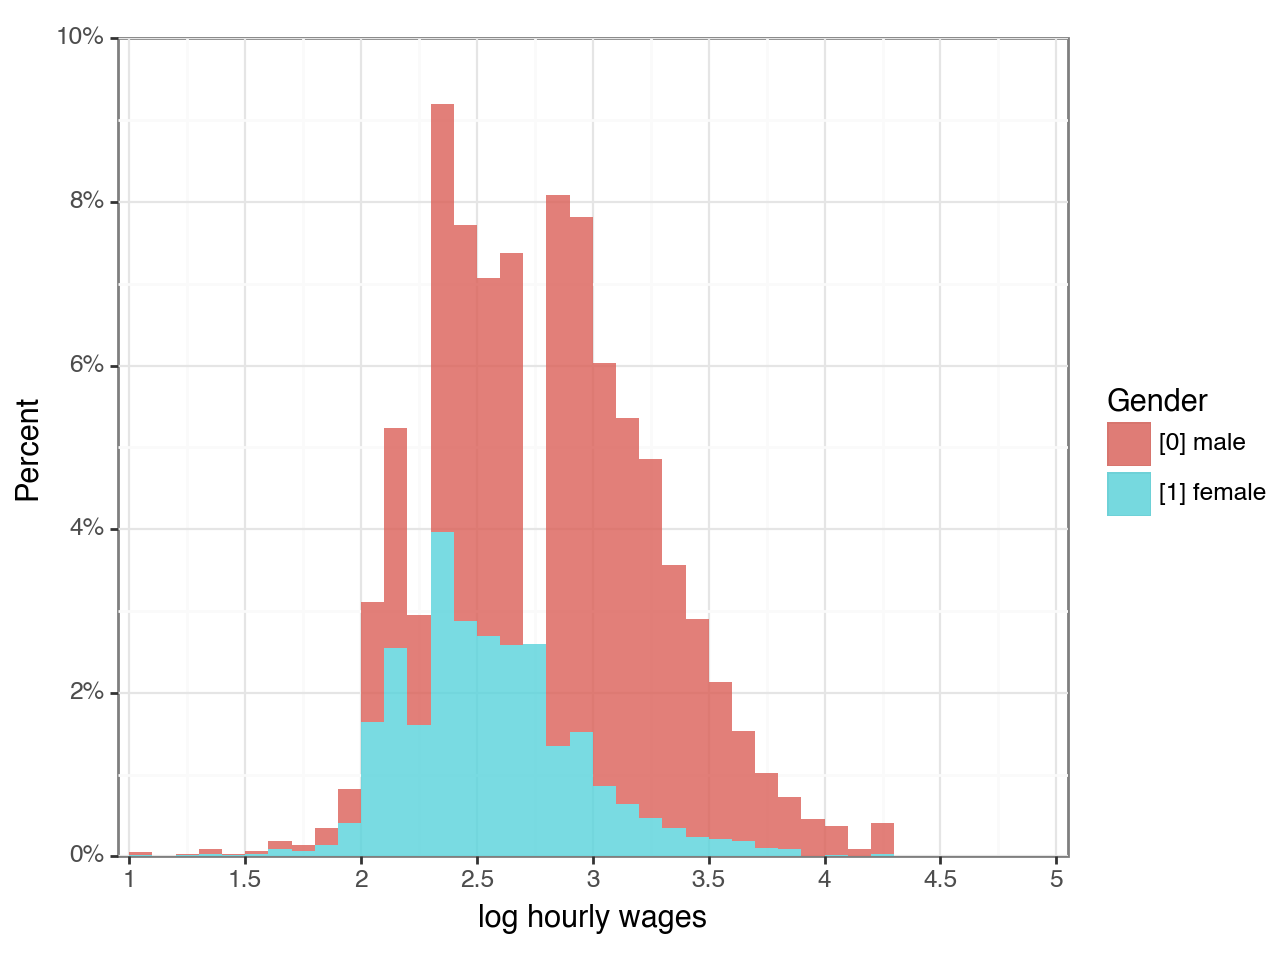

<Figure Size: (640 x 480)>

In [6]:
(
    ggplot(comp_sample, aes(x="ln_wage", y="stat(count)/sum(stat(count))", fill='factor(sex_text)'))
    + geom_histogram(
        binwidth=0.1,
        boundary=0,
        size=0.25,
        alpha=0.8,
        show_legend=True,
        na_rm=True,
    )
    + labs(x="log hourly wages", y="Percent", fill="Gender")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(1, 5), breaks=seq(1, 5, 0.5))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.1),
        breaks=seq(0, 0.1, 0.02),
        labels=percent_format(), #mizani
    )
    + theme_bw()
)

**Comment**

From the above histogram, it seems like in our sample, there are a lot more observations for male's wage than female's wage (almost 3 to 1!). We see that the Production Occupations mighty male-dominant.

## The unconditional gender gap <a name="the-unconditional-gender-gap"></a>

Here we will examine the hourly wage gap between male and female in our sample.

**Reg1 - Regression of ln(wage) on gender**

In [7]:
reg1 = smf.ols(formula="ln_wage~female", data=comp_sample).fit(cov_type="HC1")
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ln_wage   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     829.1
Date:                Tue, 21 Nov 2023   Prob (F-statistic):          1.51e-174
Time:                        18:09:55   Log-Likelihood:                -6324.2
No. Observations:                9083   AIC:                         1.265e+04
Df Residuals:                    9081   BIC:                         1.267e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8505      0.006    458.776      0.000       2.838       2.863
female        -0.3065      0.011    -28.794      0.000      -0.327      -0.286
==============================================================================
Omnibus:                     3672.023   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            93657.937
Skew:                          -1.372   Prob(JB):                         0.00
Kurtosis:                      18.490   Cond. No.                         2.45
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

**Analysis Explanation**

From the regression, we see that the P value is 0.000, which indicates that we have strong evidences to reject 
the hypothesis that there is no difference in wage between male and female.

The coefficient of -0.3097 and the standard error of 0.011 suggest that female employees earn between 29.8%-32.0% less than male employees. If our sample is a representative sample, this behavior is very likely to happen in the population since our p-value is < 0.01.

> However, the R-squared for this model is only 0.073, which means the model only explains about 7.3% of the variance in the wage. There might be other factors that contribute to the wage aside from gender.

## The gender wage gap and education level <a name="the-gender-wage-gap-and-education-level"></a>

Let's create some dummy variables for the education level:
1. Bachelor
2. Post-Graduate Degree

In [8]:
# create dummy variables
comp_sample['ed_BA'] = (comp_sample["grade92"] == 43).astype(int)
comp_sample['ed_PostGrad'] = (comp_sample["grade92"] >= 44).astype(int)

### Gender wage gap with type of degree earned <a name="type-of-degree-earned"></a>

In [9]:
reg2 = smf.ols(formula="ln_wage~female+ed_BA+ed_PostGrad", data=comp_sample).fit(cov_type="HC1")

In [10]:
stargazer = Stargazer([reg1, reg2])
stargazer.show_model_numbers(True)
stargazer.cov_spacing = 1.5
stargazer.covariate_order(
    [
        "female",
        "ed_BA",
        "ed_PostGrad",
        "Intercept"
    ]
)
stargazer.rename_covariates(
    {
        "Intercept": "Constant"
    }
)
stargazer

**Analysis Explanation**

- (1) $\ln(w)=\alpha + \beta female + \varepsilon$
- (2) $\ln(w)=\beta_0 + \beta_1 female + \beta_2 ed\_BA + \beta_3 ed\_PostGrad + e$

> [The comparison group is employees without a Bachelor or Post Graduate Degree] 

When comparing the employees with the same gender, we we discover some insights as follow:
- Those with a Bachelor degree are expected to earn on average 26% more than those that do not have a degree.
- With a Post Graduate degree, employees are expected to earn on average 45% more than those that do not have a degree.

Both of the insights above are significant at 1%. We can also see that by including the education, the model (2) fit (R-squared) is better than the unconditional model (1).

From the model, estimated coefficient on *female* is smaller (-0.306) when education is included. It seems women appear to be more likely to be in lower-earner without a degree than in higher-earner with a degree - but only small part.

There is a positive correlation between the level of education (academic degree earners) and the wage. How about the wage gap behavior among the top degree earners?

### Gender wage gap among Post Graduate degree earners <a name="post-graduate-degree-earners"></a>

Now let's consider only among the Post Graduate degree earners:

In [11]:
# employees with post graduate degree
degree_sample = comp_sample[(comp_sample['grade92'] >= 44)]
degree_sample["ed_MA"] = (degree_sample["grade92"] == 44).astype(int)
degree_sample["ed_Prof"] = (degree_sample["grade92"] == 45).astype(int)
degree_sample["ed_PhD"] = (degree_sample["grade92"] == 46).astype(int)

In [12]:
reg3 = smf.ols(formula="ln_wage~female", data=degree_sample).fit(cov_type="HC1")
reg4 = smf.ols(formula="ln_wage~female+ed_Prof+ed_PhD", data=degree_sample).fit(cov_type="HC1")
reg5 = smf.ols(formula="ln_wage~female+ed_Prof+ed_MA", data=degree_sample).fit(cov_type="HC1")

In [13]:
stargazer = Stargazer([reg3, reg4, reg5])
stargazer.show_model_numbers(True)
stargazer.cov_spacing = 1.5
stargazer.covariate_order(
    [
        "female",
        "ed_Prof",
        "ed_MA",
        "ed_PhD",
        "Intercept"
    ]
)
stargazer.rename_covariates(
    {
        "Intercept": "Constant"
    }
)
stargazer

**Analysis Explanation**

- (1) $\ln(w)=\alpha + \beta female + \varepsilon$
- (2) $\ln(w)=\beta_0 + \beta_1 female + \beta_2 ed\_Prof + \beta_3 ed\_PhD + e$

> [The comparison group is employees with the MA degree] 

- (3) $\ln(w)=\beta_0 + \beta_1 female + \beta_2 ed\_Prof + \beta_3 ed\_MA + e$

> [The comparison group is employees with the PhD degree] 

Intertingly, when considering only the groups of Post Graduate degree earners, it seems like there is no statistical significant difference in wage regarding the type of degree earned (No `*` next to the coefficients). Even the gender wage gap in this group is not statistically significant. 

This suggests that there is likely no significant difference in wage regarding gender or type of Post Graduate degree among the top degree earners in the population.

#### Interaction between gender and level of education <a name="interaction-gender-education"></a>

Are wage patterns with education level similar or different for male vs female employees?
- Regress the ln(wage) on level of education separately for male vs female
- Include interaction $gender*degree\_earner$

Let's construct some regression model to exammine how the interaction between gender and degree earned contributes to wage.

In [14]:
# add the ed_degree to signify wether the employee has earned an academic degree
comp_sample['ed_degree'] = ((comp_sample['ed_BA'] == 1) | (comp_sample['ed_PostGrad'] == 1)).astype(int)
reg6 = smf.ols(formula="ln_wage~ed_degree", data=comp_sample.query("female==1")).fit(cov_type="HC1")
reg7 = smf.ols(formula="ln_wage~ed_degree", data=comp_sample.query("female==0")).fit(cov_type="HC1")
reg8 = smf.ols(formula="ln_wage~female+ed_degree+female*ed_degree", data=comp_sample).fit(cov_type="HC1")

In [15]:
stargazer = Stargazer([reg6, reg7, reg8])
stargazer.custom_columns(['female', 'male', 'all'], [1, 1, 1])
stargazer.show_model_numbers(True)
stargazer.cov_spacing = 1.5
stargazer.covariate_order(
    [
        "female",
        "ed_degree",
        "female:ed_degree",
        "Intercept"
    ]
)
stargazer.rename_covariates(
    {
        "Intercept": "Constant",
        "female:ed_degree": "female x degree earner"
    }
)
stargazer

**Analysis Explanation**

- (1): female employees with a degree are expected to earn 36% more, on average
- (2): male employees with a degree are expected to earn 26% more, on average
- (3): the slope of log earnings - level of education pattern is 0.105 more positive for female, on average

Interestingly, the level of education has a higher positive correlation to wage between female to female than that of male to male. 

However, there is still a gender wage gap between female and male employees where female earn on average 31% less than male employee with the same academic degree/qualification.